# Analyzing NYC High School Data

## Introduction

In this small project we will look at NYC high schools data and analyze to find interesting insights. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

**Datasets were obtained in** [this website](https://data.cityofnewyork.us/browse?category=Education)

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

- SAT scores by school - SAT scores for each high school in New York City
- School attendance - Attendance information for each school in New York City
- Class size - Information on class size for each school
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes - The percentage of students who graduated, and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

The dataframe **combined** contains all of the data we'll be using in our analysis

## Read in Data

In [1]:
# preparing the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# creating data dictionary
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

Survey dataset contains of two .txt files. Because they cannot be read into csv directly, we will set parameters such as delimiter, and encoding. Reading these files in default 'utf-8' raises an error, as they were decoded in 'windows-1252'

> column **DBN** is the index column that will be used to merge all the datasets. 

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding="windows-1252")
survey = pd.concat([all_survey, d75_survey], axis=0)

survey['DBN'] = survey['dbn']

survey_fields = [
        "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11"
]

survey = survey.loc[:, survey_fields]
data['survey'] = survey

/Users/imuminov/anaconda3/envs/NOTEBOOK/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


## Add DBN columns

As mentioned above, **DBN** is a main col for merging, we need to clean this column and standardize across datasets

In [3]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def padding_zero(col):
    col = str(col)
    if len(col) < 2:
        col = col.zfill(2)
    return col
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(padding_zero)

data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

## Converting columns to numeric

Some cols with numeric values are not in numeric format, we will convert them for calculation and analysis

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")


data['sat_results']['sat_score'] = (data['sat_results'][cols[0]] + 
                                    data['sat_results'][cols[1]] + 
                                    data['sat_results'][cols[2]])

# extracting latitudes from dataset. 
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# extracting longitudes.
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon


data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)


data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

Because some datasets are very large and contains unnecesarry information, we will condense them, so that only data for High schools will be kept. 

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)## Combine Datasets

## Add a School district col

School district is a two digit number that represents the district that the school is located at. It is different from Borough (Manhattan, Bronx etc.). We will extract them in a seperate col. 

In [8]:
combined['school_dist'] = combined['DBN'].str[0:2]

## Find Correlations

Now it is time for an actual analysis as we have prepared the data. 

We will start by finding correlations between survey results and average sat_scores for schools. 

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64

## Plotting survey correlations

Here we will look at the correlations between survey data and sat_score, to find out whether school atmosphere and administration scores have impact on sat_scores. 

Just to remind,  here is the definition of cols in survey data. The scores range from 0 to 10. 


Column Name | Definition
--|--
rr_s|	Student Response Rate
rr_t|	Teacher Response Rate
rr_p|	Parent Response Rate
N_s|	Number of student respondents
N_t|	Number of teacher respondents
N_p|	Number of parent respondents
nr_s|	Number of eligible students
nr_t|	Number of eligible teachers
nr_p|	Number of eligible parents
saf_p_10|	Safety and Respect score based on parent responses
com_p_10|	Communication score based on parent responses
eng_p_10|	Engagement score based on parent responses
aca_p_10|	Academic expectations score based on parent responses
saf_t_10|	Safety and Respect score based on teacher responses
com_t_10|	Communication score based on teacher responses
eng_t_10|	Engagement score based on teacher responses
aca_t_10|	Academic expectations score based on teacher responses
saf_s_10|	Safety and Respect score based on student responses
com_s_10|	Communication score based on student responses
eng_s_10|	Engagement score based on student responses
aca_s_10|	Academic expectations score based on student responses
saf_tot_10|	Safety and Respect total score
com_tot_10|	Communication total score
eng_tot_10|	Engagement total score
aca_tot_10|	Academic Expectations total score

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.append('sat_score')
survey_correlations = combined[survey_fields].corr()['sat_score']

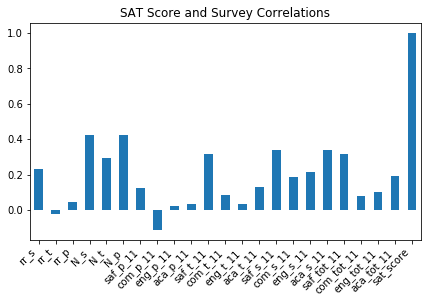

In [11]:
import seaborn as sns

ax = survey_correlations.plot.bar(figsize=(7,4))
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
ax.set_title('SAT Score and Survey Correlations')
plt.show()

## Interpreting correlations
 
- N_s           0.423463 : Number of Student Respondents
- N_t           0.291463 : Number of teacher respondents
- N_p           0.421530 : Number of parent respondents
- saf_t_11      0.313810 : Safety and Respect score based on teacher responses
- saf_s_11      0.337639 : Safety and respect scores based on student responses
- aca_s_11      0.339435 : Academic expectations score based on sutdents responses
- saf_tot_11    0.318753 : Safety and respect total score

There are the correlations higher than .25, which should not be neglected. 

- Safety and respect score based on teachers and students are very close in value. 

- academic expectations do have some impact on sat score, well based on this number

- safety total is close to safety and respect based on specific people

## Exploring safety and SAT scores

Interestingly safety score and sat_score have a positive correlation of clost to .4. This might not be significant, but it is still interesting to look at it. 

For that we will draw scatter plot of safety and sat_scores

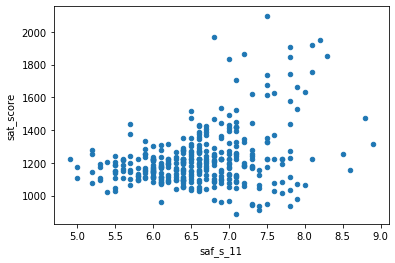

In [12]:
combined.plot.scatter('saf_s_11', 'sat_score')
plt.show()

Safety and Respect score have a very little correlation with SAT scores, they do have some common traits, but it is too far sketched to say that one is caused by the other. 

In [13]:
# Average safety score by district
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)
districts['saf_s_11'].sort_values(ascending=False).head(10)

19    7.120000
11    7.116667
23    7.107692
29    7.033333
21    7.025000
5     6.950000
24    6.912500
1     6.910660
3     6.885714
6     6.800000
Name: saf_s_11, dtype: float64

Mapping schools by districts, and color the map in according to safety scores. 

We will use *'summer'* colormapping, which means that blue color means lower safety score, and yellow higher safety score. 

/Users/imuminov/anaconda3/envs/NOTEBOOK/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/Users/imuminov/anaconda3/envs/NOTEBOOK/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


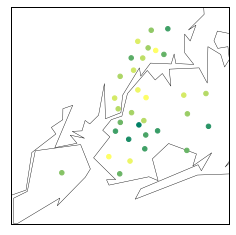

In [14]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary()
m.drawcoastlines(linewidth=.4)
m.drawrivers(linewidth=.4, color='#6D5F47')

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')
plt.show()

We can see that Manhattan has more low values for safety compared to other four boroughs. The Bronx is second least safe district for schools. 

## Exploring Race and SAT Scores

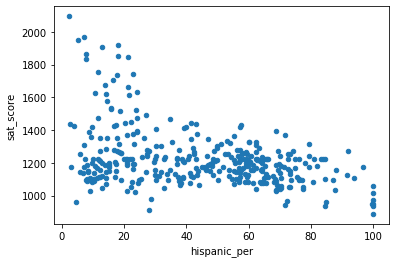

In [15]:
combined.plot.scatter('hispanic_per', 'sat_score')
plt.show()

Interestingly, schools with more hispanic studetns score low on SAT test. If that is not enough, schools with 100 hispanic students scored relatively low. We need to further investigate the reason. 

## Research schools with more than 95% of hispanic students.

In [16]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'Location 1', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'BBL', 'NTA', 'lat', 'lon', 'school_dist'],
      dtype='object', length=166)

In [17]:
hispanic_majority_schools = combined[combined['hispanic_per'] > 95]
hispanic_majority_schools

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,"525 West 50Th Street\nNew York, NY 10019\n(40....",4.000000,3.000000,135.000000,1.083802e+06,1.010790e+09,Clinton ...,40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,"511 West 182Nd Street\nNew York, NY 10033\n(40...",12.000000,10.000000,269.000000,1.063703e+06,1.021550e+09,Washington Heights North ...,40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,"501 West 165Th\nNew York, NY 10032\n(40.838032...",6.792244,22.238227,3760.027701,2.587480e+06,2.515083e+09,0,40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.000000,14.000000,21502.000000,2.008460e+06,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",7.000000,11.000000,409.000000,2.015241e+06,2.032470e+09,Van Cortlandt Village ...,40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",9.000000,18.000000,56.000000,2.027459e+06,2.038640e+09,West Farms-Bronx River ...,40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",5.000000,37.000000,1180.000000,3.090738e+06,3.040940e+09,park-cemetery-etc-Brooklyn ...,40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,"45 10 94Th Street\nElmhurst, NY 11373\n(40.743...",4.000000,25.000000,463.000000,4.437166e+06,4.016000e+09,Elmhurst ...,40.743303,-73.870575,24


After finding more information about the school from wikipedia and their respective websites, it was found that these schools are specifically designed to accomodate students from hispanic background, to welcome the newcomers and satisfy the needs of families for knowledge. 

## Research schools with less than 10% hispanic students

In [18]:
hispanic_minority_schools = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
hispanic_minority_schools['SCHOOL NAME'].head(10)

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Findings:
- Stuyvesant High Schools is very high profile institution, only bright minds are accepted, because the competition is fierce in this place.
- HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES, for students who can speak english and chinese. 
- Similar to Stuy, only 900 of 30,000 applicants are accepted to this place.
- Brooklyn technical high school is one of three specialized high schools under NYCDE. Very elite, probably expensive. 
- Bedford Academy High schools is small, academically demanding high school. Very demanding. 

These suggest that Hispanic Minority high schools are very elite and specialized high schools. It is clear why Hispanic students are less common in these places. They must be quite expensive as well. 

## Exploring Gender and SAT Scores

In [19]:
gender_correlation = combined[['sat_score', 'male_per', 'female_per']].corr()
gender_correlation

,sat_score,male_per,female_per
sat_score,1.000000,-0.112062,0.112108
male_per,-0.112062,1.000000,-1.000000
female_per,0.112108,-1.000000,1.000000


Gender and SAT scores are not correlated at all. It is impossible to say that being male or female is somehow going to affect SAT score. 

## Female_per and sat_score scatter plot

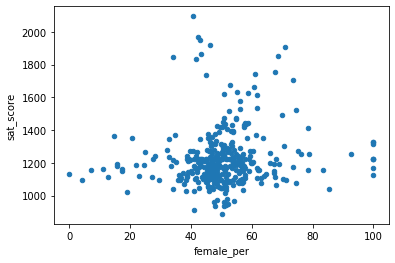

In [20]:
combined.plot.scatter('female_per', 'sat_score')
plt.show()

It is hard to deduct something decisive from this plot. We could say that female percentage is dominant at 40-60% range in most schools. SATs kind of experiences high scores in that range, or 40-80% range. Could this mean that Female Majority schools score high on SATs. We will find out. 

In [21]:
female_majority_schools = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
female_majority_schools[['SCHOOL NAME','female_per']]

,SCHOOL NAME,female_per
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5
60,BEACON HIGH SCHOOL,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,71.1


- Bard High school early college is reputable alternative publuc secondary high school. Interestingly, it offers alternative education, which uses different pedagogy methods to those traditional ones. established in 2001
- Eleanor Roosevelt High School: could not find nothing special about this school, except that it was established in 2002
- Beacon High School: Selective college-preparatory public high schools. 
- Fiorello Laguardia is specialized in visual arts and performing arts.
- Townsend Harris high school is specialied for the humanities. 

> **we can see that these high schools are specialized in liberal arts, rather than science.**

## Exploring AP Scores vs SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

             ap_per  sat_score
ap_per     1.000000   0.057171
sat_score  0.057171   1.000000


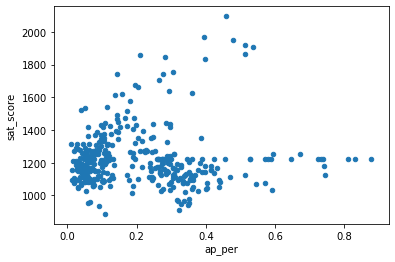

In [22]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter('ap_per', 'sat_score')
print(combined[['ap_per', 'sat_score']].corr())
plt.show()

There is no strong relationship between these two cols. Although, as the proportion of AP test takers increase, there is an overall increase in SAT scores as well, but it is not predominant. 

## Next Steps

We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:

- Determing wheter there's a correlation between class size and SAT scores
- Figuring out which neighborhoods have the best schools
    - If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
- Investigating the differences between parent, teacher, and student responses to surveys.
- Assigning scores to schools based on sat_score and other attributes.

We recommend creating a [GitHub](https://github.com/) repository and placing this project there. It will help other people see your work, including employers. As you start to put multiple projects on GitHub, you'll have the beginnings of a strong portfolio.

You're welcome to keep working on the project here, but we recommend downloading it to your computer using the download icon above and working on it there.

## Class size and SAT Score correlation

In [23]:
class_size_cols = data['class_size'].columns.tolist()
class_size_cols.append('sat_score')

In [24]:
combined[class_size_cols].corr()['sat_score']

CSD                                  0.042948
NUMBER OF STUDENTS / SEATS FILLED    0.394626
NUMBER OF SECTIONS                   0.362673
AVERAGE CLASS SIZE                   0.381014
SIZE OF SMALLEST CLASS               0.249949
SIZE OF LARGEST CLASS                0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO            NaN
sat_score                            1.000000
Name: sat_score, dtype: float64

There seems to be a little correlation between class size and sat score. The bigger the Class size, the higher the SAT. Lets look at the scatter plot. 

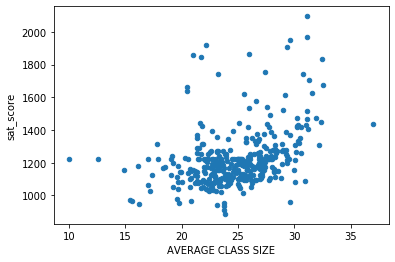

In [25]:
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score')
plt.show()

## Finding Neighborhood with best schools. 

In order to identify the best neighborhood in terms of best schools, we need to choose the cols that could potentially describe the quality of school. 

> Possible cols:
- Survey data cols.
    - saf_p_10
    - com_p_10
    - eng_p_10
    - aca_p_10
    - saf_t_10
    - com_t_10
    - eng_t_10
    - aca_t_10
    - saf_s_10
    - com_s_10
    - eng_s_10
    - aca_s_10
    - saf_tot_10
    - com_tot_10
    - eng_tot_10
- sat_score.
- ap_per. 

In [26]:
school_quality_cols = [
    'sat_score',
    'ap_per',
    'saf_p_11',
    'com_p_11',
    'eng_p_11',
    'aca_p_11',
    'saf_t_11',
    'com_t_11',
    'eng_t_11',
    'aca_t_11',
    'saf_s_11',
    'com_s_11',
    'eng_s_11',
    'aca_s_11',
    'saf_tot_11',
    'com_tot_11',
    'eng_tot_11',
    'aca_tot_11']
school_quality = combined[school_quality_cols]
school_quality.head()

,sat_score,ap_per,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,1122.0,0.305756,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0
1,1172.0,0.098985,7.9,7.4,7.2,7.3,6.6,5.8,6.6,7.3,6.000000,5.700000,6.300000,7.000000,6.8,6.3,6.7,7.2
2,1149.0,0.031773,8.7,8.2,8.1,8.4,7.3,8.0,8.0,8.8,6.611667,6.094722,6.620278,7.381389,7.9,7.9,7.9,8.4
3,1207.0,0.351577,7.7,7.4,7.2,7.3,6.4,5.3,6.1,6.8,6.400000,5.900000,6.400000,7.000000,6.9,6.2,6.6,7.0
4,1621.0,0.158091,8.5,7.9,7.9,8.4,7.6,5.6,5.9,7.3,7.300000,6.400000,7.000000,7.700000,7.8,6.7,6.9,7.8


In this subset of dataset, we have survey scores, sat_score, and percentage of ap test takers. In order to simplify calculation, we will find average score based on all survey cols. 

In [27]:
survey_cols = school_quality.iloc[:, 2:].copy()
school_quality['quality_score'] = survey_cols.sum(axis=1) / survey_cols.shape[1]

/Users/imuminov/anaconda3/envs/NOTEBOOK/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
school_quality.head()

,sat_score,ap_per,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,quality_score
0,1122.0,0.305756,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0,6.600000
1,1172.0,0.098985,7.9,7.4,7.2,7.3,6.6,5.8,6.6,7.3,6.000000,5.700000,6.300000,7.000000,6.8,6.3,6.7,7.2,6.756250
2,1149.0,0.031773,8.7,8.2,8.1,8.4,7.3,8.0,8.0,8.8,6.611667,6.094722,6.620278,7.381389,7.9,7.9,7.9,8.4,7.769253
3,1207.0,0.351577,7.7,7.4,7.2,7.3,6.4,5.3,6.1,6.8,6.400000,5.900000,6.400000,7.000000,6.9,6.2,6.6,7.0,6.662500
4,1621.0,0.158091,8.5,7.9,7.9,8.4,7.6,5.6,5.9,7.3,7.300000,6.400000,7.000000,7.700000,7.8,6.7,6.9,7.8,7.293750


Because we calculated the overall quality score, we will only keep cols sat_score, ap_per, and quality_score. 

In [29]:
school_quality = school_quality[['sat_score', 'ap_per', 'quality_score']]
school_quality.head()

,sat_score,ap_per,quality_score
0,1122.0,0.305756,6.600000
1,1172.0,0.098985,6.756250
2,1149.0,0.031773,7.769253
3,1207.0,0.351577,6.662500
4,1621.0,0.158091,7.293750


Now we have the factors that tell about the school quality, we need to find a way to standardize the scores, in order to rank them. A good way is to go with percentages. So our standardized score will be between 0 and 100. 

- ap_per column is already in percentage, only needs to be multiplied by 100.
- sat_score needs to be converted to percentage. We know that maximum score is 2400 for SAT, so converting is easy-peasy. 
- and for quality, also easy, just need to multiply by 10, because the score in 0 to 10 range. 

After that, we will create single column for overall school quality rank. we will call it school_score


In [30]:
# standardizing cols to percentage 
school_quality['ap_per'] = school_quality['ap_per'] * 100
school_quality['sat_score'] = school_quality['sat_score'] / 2400 * 100
school_quality['quality_score'] = school_quality['quality_score'] * 10


# adding school_score col: averageof all three cols. 
school_quality['school_score'] = (school_quality['quality_score'] + 
                                  school_quality['sat_score'] + 
                                  school_quality['ap_per']) / 3


school_quality.head()

,sat_score,ap_per,quality_score,school_score
0,46.750000,30.575556,66.000000,47.775185
1,48.833333,9.898477,67.562500,42.098103
2,47.875000,3.177258,77.692535,42.914931
3,50.291667,35.157724,66.625000,50.691463
4,67.541667,15.809051,72.937500,52.096073


Now we have school_score col, we will add this to combined dataset, and print top 10 schools by school_score. 

In [31]:
import IPython.display

In [32]:
combined['school_score'] = school_quality['school_score']
school_score = combined[['SCHOOL NAME', 'school_score']].sort_values('school_score', ascending=False)
top10_schools = school_score.head(10).reset_index()
worst_schools = school_score.tail(10).reset_index()
display(top10_schools)
display(worst_schools)

,index,SCHOOL NAME,school_score
0,335,CAMBRIA HEIGHTS ACADEMY,73.167114
1,111,BRONX BRIDGES HIGH SCHOOL,71.573678
2,155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,71.298795
3,356,STATEN ISLAND TECHNICAL HIGH SCHOOL,70.712862
4,302,TOWNSEND HARRIS HIGH SCHOOL,69.451754
5,31,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,69.319129
6,37,STUYVESANT HIGH SCHOOL,68.252515
7,327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,67.839580
8,83,HIGH SCHOOL FOR EXCELLENCE AND INNOVATION,67.613244
9,33,INTERNATIONAL HIGH SCHOOL AT UNION SQUARE,67.304487


,index,SCHOOL NAME,school_score
0,253,MULTICULTURAL HIGH SCHOOL,38.848591
1,331,PATHWAYS COLLEGE PREPARATORY SCHOOL: A COLLEGE...,38.825075
2,358,EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK,38.758870
3,75,ACADEMY FOR SOCIAL ACTION: A COLLEGE BOARD SCHOOL,38.479167
4,159,ACADEMY FOR SCHOLARSHIP AND ENTREPRENEURSHIP: ...,38.125688
5,101,ALFRED E. SMITH CAREER AND TECHNICAL EDUCATION...,37.871838
6,220,BOYS AND GIRLS HIGH SCHOOL,37.852400
7,65,FREDERICK DOUGLASS ACADEMY II SECONDARY SCHOOL,37.318368
8,315,AUGUST MARTIN HIGH SCHOOL,36.400207
9,306,MARTIN VAN BUREN HIGH SCHOOL,36.393015


We have 5 neighborhoods in NYC, so now we can find the neighborhood with best schools. 

For that, we will use 'borough' col in combined dataset

In [33]:
boroughs = combined.groupby('borough').agg(np.mean)
borough_rank = boroughs[['school_score', 'sat_score']].sort_values('school_score', ascending=False)
borough_rank

,school_score,sat_score
borough,,
Manhattan,49.956996,1278.331410
Staten Island,49.133457,1382.500000
Queens,48.040595,1286.753032
Brooklyn,47.324475,1181.364461
Bronx,46.338401,1157.598203


Our findings suggest that Manhattan is the best neighborhood in terms of overall school quality. However, highest sat_score belongs to Staten Island. In order to better understand this score, we also need number of schools in each borough. Without the total number of schools, we might be biased to one of them. 

In [34]:
school_count = combined.groupby('borough').count()
borough_rank['count'] = school_count['DBN']

In [35]:
borough_rank

,school_score,sat_score,count
borough,,,
Manhattan,49.956996,1278.331410,90
Staten Island,49.133457,1382.500000,10
Queens,48.040595,1286.753032,64
Brooklyn,47.324475,1181.364461,106
Bronx,46.338401,1157.598203,93


Staten Island only has 10 schools, this could be a reason for it to have higher score on SATs. Anyway, we can conclude that Manhattan has the best schools overall. 

## Conclusion. 

In this data analysis, we looked at several datasets relating to High Schools under New York City Department of Education. Analysis brought some interesting insights and overall picture of schools in NYC. This analysis can be further expanded to find more facts, and reflect upon them. 

# Thank you. 